**Udemy 8-5. VIP Making Predictions with a Trained Recommender Model**

Top 10 recommendation for a user

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [85]:
# data is from: https://grouplens.org/datasets/movielens/
# MovieLens 20M movie ratings. Stable benchmark dataset. 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags. Released 4/2015; updated 10/2016 to update links.csv and add tag genome data.
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [86]:
!unzip -n /content/ml-20m.zip
# -n : never overwrite existing files. If a file already exists, skip the extraction of that file without prompting.

Archive:  /content/ml-20m.zip


In [87]:
!ls

ml-20m	ml-20m.zip  sample_data


In [88]:
df = pd.read_csv("/content/ml-20m/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [89]:
# We can't trust the userID and movieID to be numbered 0...N-1
# Let;s just set our own ids

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [90]:
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [91]:
# Get the number of users and movies 
N = len(set(user_ids))
M = len(set(movie_ids))

In [92]:
# Set the embeding dimension
D = 10

In [93]:
# Make a Neural Network
class Model(nn.Module):
  def __init__(self, n_users, n_movies, embed_dim, n_hidden=1024):
    super().__init__()
    self.N = n_users
    self.M = n_movies
    self.D = embed_dim

    self.u_emb = nn.Embedding(num_embeddings=self.N, embedding_dim=self.D)
    self.m_emb = nn.Embedding(num_embeddings=self.M, embedding_dim=self.D)

    self.fc1 = nn.Linear(in_features=2*self.D, out_features=n_hidden)
    self.fc2 = nn.Linear(in_features=n_hidden, out_features=1)

    # set the weights since N(0,1) leads to poor results
    self.u_emb.weight.data = nn.Parameter(torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_emb.weight.data = nn.Parameter(torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
  
  def forward(self, u, m):
    u = self.u_emb(u) # the output is (number_of_samples, D)
    m = self.m_emb(m) # the output is (number_of_samples, D)

    # merge
    out = torch.cat((u,m), dim=1) # the output is (number_of_samples, 2D)

    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out


In [94]:
model = Model(n_users=N, n_movies=M, embed_dim=D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [95]:
# Loss and Optimizer
criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [96]:
# A function to encapsulate the training loop


def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data
  
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / bs))

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    
    # Shuffle
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]

      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)

      # reshape targets
      targets = targets.view(-1,1).float()

      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the gradients
      optimizer.zero_grad()

      # Forward Pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)

      # backward pass
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    
    # Get the train loss and test loss
    train_losses[it] = np.mean(train_loss)
    
    test_loss = []
    for j in range(int(np.ceil(len(test_users)/ bs))):
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]

      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)

      # reshape targets
      targets = targets.view(-1,1).float()

      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      outputs = model(users, movies)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())

    test_losses[it] = np.mean(test_loss)
    dt = datetime.now() - t0
    print(f"Epoch: {it+1}/{epochs}, Train Loss: {train_loss[it]:.4f}, Test Loss: {test_loss[it]:.4f}, Duration: {dt}")
  return train_losses, test_losses


In [97]:
# Shuffle data in corresponding order
user_ids, movies_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [98]:
Ntrain = int(0.8 * len(ratings))

train_users = user_ids[:Ntrain]
train_movies = movies_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movies_ids[Ntrain:]
test_ratings = ratings[Ntrain:]


In [99]:
train_losses, test_losses = batch_gd2(
    model, 
    criterion, 
    optimizer, 
    (train_users, train_movies, train_ratings), 
    (test_users, test_movies, test_ratings), 
    epochs=10,
    bs=512
    )

Epoch: 1/10, Train Loss: 2.4654, Test Loss: 0.7505, Duration: 0:00:51.478945
Epoch: 2/10, Train Loss: 0.6397, Test Loss: 0.6714, Duration: 0:00:58.394286
Epoch: 3/10, Train Loss: 0.6320, Test Loss: 0.6768, Duration: 0:00:50.017461
Epoch: 4/10, Train Loss: 0.5412, Test Loss: 0.6743, Duration: 0:01:03.208559
Epoch: 5/10, Train Loss: 0.5552, Test Loss: 0.6198, Duration: 0:00:50.747026
Epoch: 6/10, Train Loss: 0.5448, Test Loss: 0.6791, Duration: 0:00:46.233898
Epoch: 7/10, Train Loss: 0.4862, Test Loss: 0.5850, Duration: 0:00:45.490620
Epoch: 8/10, Train Loss: 0.4771, Test Loss: 0.5813, Duration: 0:01:04.969435
Epoch: 9/10, Train Loss: 0.5400, Test Loss: 0.7007, Duration: 0:01:00.243920
Epoch: 10/10, Train Loss: 0.5098, Test Loss: 0.7229, Duration: 0:00:46.928453


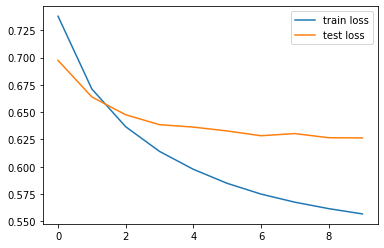

In [100]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [101]:
# Suppose I want to find recommendation for user_id = 1
# First find all the movie_ids they haven't ye watched
watched_movie_ids = df[df.new_user_id==1].new_movie_id.values
watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [102]:
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()
print(potential_movie_ids.shape)

(26683,)


In [103]:
# Repeat the user_id this many time (for user_id=1)
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [104]:
# convert to torch tensor
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# Get Prediction
with torch.no_grad():
  predictions = model(t_user_ids, t_movie_ids)

In [105]:
# Convert predictions to Numpy
predictions_np = predictions.cpu().numpy().flatten()

In [106]:
# Get sort index for predictions
sort_idx = np.argsort(-predictions_np) # in order to sort descending
sort_idx

array([   18,   183,   205, ..., 13520,  8795,  8583])

In [108]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print(f"movie: {movie}, score: {score}")

movie: 1017, score: 2.6240956783294678
movie: 843, score: 2.5183117389678955
movie: 1195, score: 2.4922451972961426
movie: 1343, score: 2.4606709480285645
movie: 453, score: 2.451286554336548
movie: 1263, score: 2.423631191253662
movie: 10109, score: 2.419886350631714
movie: 1176, score: 2.418745994567871
movie: 1944, score: 2.4165053367614746
movie: 5056, score: 2.4162750244140625
